# Graph visualization

In [21]:
!pip install graphviz

In [22]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ value %.4f | grad %.4f }" % (n.value, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

# Xem xét một số ví dụ từ bài học trước:


```
1. f(x, y, z) = (x+y)*z

2. f(x,t0,t1) = 1 / (1 + exp(-(t0 + t1*x)))
```



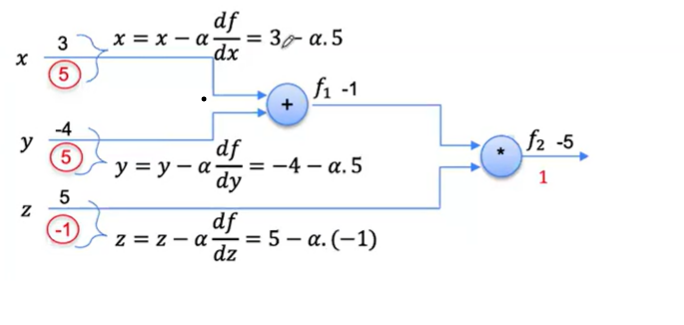

In [1]:
import numpy
def func1(x,y,z):
  return (x+y)*z

def func2(x,t0,t1):
  return 1 / (1 + np.exp(-(t0 + t1*x)))

In [4]:
eps = 1e-5
x, y, z = 3, -4, 5

dx = (func1(x+eps, y, z) - func1(x, y, z))/eps
dy = (func1(x, y+eps, z) - func1(x, y, z))/eps
dz = (func1(x, y, z+eps) - func1(x, y, z))/eps
print(dx, dy, dz)

4.999999999988347 4.999999999988347 -0.9999999999621422


# Thuật toán Backpropagation
## 1. Pytorch và backpropagation

In [116]:
import torch
from torch.autograd import Variable

x = Variable(torch.tensor(3.0), requires_grad=True)
y = Variable(torch.tensor(-4.0), requires_grad=True)
z = Variable(torch.tensor(5.0), requires_grad=True)

loss = (x+y)*z
loss.backward()

In [117]:
print(x.grad)
print(y.grad)
print(z.grad)

tensor(5.)
tensor(5.)
tensor(-1.)


## 2. Ý tưởng và phiên bản đơn giản của MicroGrad

**Implementation for MicroGrad**

*reference:*
1. https://github.com/karpathy/micrograd
2. https://www.youtube.com/watch?v=VMj-3S1tku0

In [134]:
import numpy as np

#### TODO ####
# Tạo class Var: Định nghĩa các biến có các thuộc tính như Value, Gradient value và Previous state (mảng lưu các node phía)
# Tạo các toán tử cho class Var: add, mul, sub, ...
# Định nghĩa backward function cho từng toán tử
# Định nghĩa hàm backward cho toàn đồ thị tính toán trong class Var
##############

class Var:
  def __init__(self, value, _op= ""):
    self.value = value
    self._prev = []
    self.grad = 0.0
    self._op = _op
    self._backward = lambda: None

  def __repr__(self):
    return "Value: " + str(self.value)

  def __add__(self, other: Var) -> Var:
    """
    Input:
      self: first Var
      other: second Var
    Output:
      output: Sum of self and other
    Requirements:
      1. Update _prev list
      2. Update grad value for self and other
    """
    if not isinstance(other, Var):
        other = Var(other)
    output = Var(self.value + other.value, _op= "+") # x + y
    # Update _prev list
    output._prev = [self, other]

    def _backward():
      # Update grad value for self and other
      self.grad += 1.0 * output.grad
      other.grad += 1.0 * output.grad

    output._backward = _backward
    return output

  def __mul__(self, other: Var) -> Var:
    """
    Input:
      self: first Var
      other: second Var
    Output:
      output: Multiply of self and other
    Requirements:
      1. Update _prev list
      2. Update grad value for self and other
    """
    if not isinstance(other, Var):
      other = Var(other)
    output = Var(self.value * other.value, _op= "*")
    output._prev = [self, other]
    def _backward():
      self.grad += other.value * output.grad
      other.grad += self.value * output.grad
    output._backward = _backward
    return output

  def __truediv__(self, other: Var) -> Var:
    """
    Input:
      self: first Var
      other: second Var
    Output:
      output: Devide of self and other
    Requirements:
      1. Update _prev list
      2. Update grad value for self and other
    """

    if not isinstance(other, Var):
      other = Var(other)
    output = Var(self.value / other.value, _op= "/")
    output._prev = [self, other]
    def _backward():
      self.grad += (1 / other.value) * output.grad
      other.grad += (-self.value / other.value**2) * output.grad
    output._backward = _backward
    return output

  def __neg__(self) -> Var:
    """
    Input:
      self: first Var
      other: second Var
    Output:
      output: negative value of self
    Requirements:
      1. Update _prev list
      2. Update grad value for self
    """
    output = Var(-self.value, _op= "neg")
    output._prev = [self]
    def _backward():
      self.grad += -1. * output.grad
    output._backward = _backward
    return output

  def exp(self) -> Var:
    """
    Input:
      self: first Var
      other: second Var
    Output:
      output: exponential value of self
    Requirements:
      1. Update _prev list
      2. Update grad value for self
    """
    output = Var(np.exp(self.value), _op= "exp")
    output._prev = [self]
    def _backward():
      self.grad += np.exp(self.value) * output.grad
    output._backward = _backward
    return output

  def sigmoid(self) -> Var:
    @staticmethod
    def _sigmoid(x):
      return 1 / (1 + np.exp(-x))

    output = Var(1) / (1 + (-self).exp())
    output._prev = [self]
    def _backward():
        self.grad += (_sigmoid(self.value) * (1 - _sigmoid(self.value)) * output.grad)
    output._backward = _backward
    return output

  def BCE(self, y: int) -> Var:
    output = Var(-(y*np.log(self.value) + (1-y) * np.log(1-self.value)) )
    output._prev = [self]
    def _backward():
        self.grad += (-y/self.value + (1-y)/(1-self.value))
    output._backward = _backward
    return output

  # Trick to implement reverse addition operator
  __radd__ = __add__

  def backward(self):
    """
    Calling backward for the whole calculation graph
    """
    self.grad = 1.0
    nodes = []
    visited = []
    def travel(node):
      # Recursive travel all node in graph using _prev list
      if node not in visited:
        visited.append(node)
        for child in node._prev:
          travel(child)
        nodes.append(node)
    travel(self)
    nodes.reverse()
    for node in nodes:
      node._backward()

In [118]:
x = Var(3.0)
y = Var(-4.0)
z = Var(5.0)
# L = (x.__add__(y)).__mul__(z)
L = (x + y) * z
L.backward()

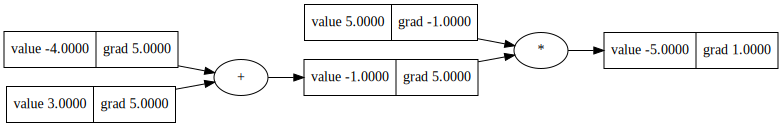

In [119]:
draw_dot(L)

In [121]:
x = Var(1.)
y = Var(-3.0)
z = Var(3.0)

def func2(x,t0,t1):
  return Var(1) / (1 + np.exp(-(t0 + t1*x)))

L = func2(x,y,z)
L.backward()

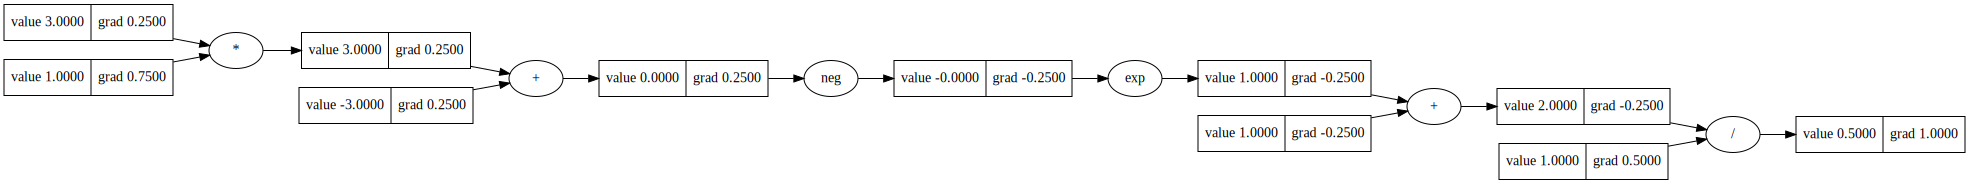

In [122]:
draw_dot(L)

## 3. Mở rộng MiniGrad với Logistic Regression

## 3.1. Khởi tạo dữ liệu thử nghiệm

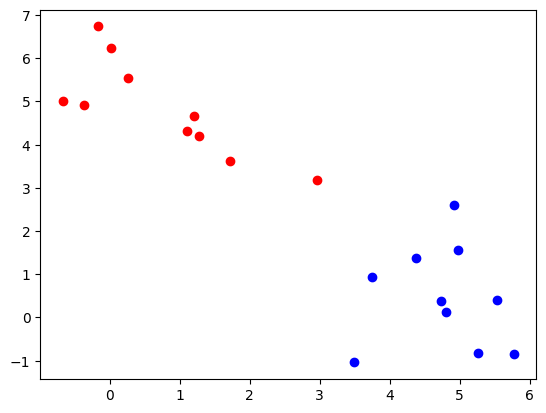

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

n_sample = 10

# Generate training data
red_points = np.random.randn(n_sample, 2) + np.array([[1,5]])
blue_points = np.random.randn(n_sample, 2) + np.array([[5,1]])
X = np.concatenate((red_points, blue_points))
Y = np.concatenate((np.ones(n_sample), np.zeros(n_sample)))
# Generate validation data
red_points_val = np.random.randn(n_sample, 2) + np.array([[1,5]])
blue_points_val = np.random.randn(n_sample, 2) + np.array([[5,1]])
X_val = np.concatenate((red_points_val, blue_points_val))
Y_val = np.concatenate((np.ones(n_sample), np.zeros(n_sample)))

X = np.concatenate((X, np.ones((2*n_sample, 1))), axis=1)
# Plot red and blue points
plt.plot(red_points[:,0], red_points[:,1], 'ro')
plt.plot(blue_points[:,0], blue_points[:,1], 'bo')

## 3.2 Cài đặt Logistic Regression với Pytorch

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

#Convert data to PyTorch tensors
X = torch.from_numpy(X).float()
y = torch.from_numpy(Y).float()

#Define logistic regression model
class LogisticRegression(torch.nn.Module):
  def __init__(self, input_size):
    super(LogisticRegression, self).__init__()
    self.linear = torch.nn.Linear(input_size, 1)

  def forward(self, x):
    out = torch.sigmoid(self.linear(x))
    return out

#Create an instance of the model
model = LogisticRegression(3)

#Define loss function
criterion = torch.nn.BCELoss()

#Define optimizer
learning_rate = 0.01
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

#Train the model
num_epochs = 100
for epoch in range(num_epochs):

  #Forward pass
  outputs = model(X)
  outputs = outputs.view(-1)

  #Compute loss
  loss = criterion(outputs, y)

  #Backward pass and update
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Print loss every 10 epochs
  if (epoch+1) % 10 == 0:
    print('Epoch: {}, Loss: {:.4f}'.format(epoch+1, loss.item()))

#Evaluate the model
with torch.no_grad():
  predicted = model(X)
  predicted = predicted.view(-1)
  correct = (predicted > 0.5).float() == y
  accuracy = correct.sum() / len(correct)
  print('Accuracy: {:.2f}'.format(accuracy))

#Plot the decision boundary and data points
w = model.linear.weight[0]
b = model.linear.bias[0]
xx = np.linspace(0, 7.0)
yy = -(w[0].item() * xx + b.item()) / w[1].item()
plt.plot(xx, yy, 'k', label='Decision boundary')
plt.scatter(X[:,0], X[:,1], c=y.numpy(), s=40, cmap=plt.cm.Spectral)
plt.legend()
plt.show()

## 3.3 Cài đặt Logistic Regression from scratch

133.28216043383796
129.81824878116728
126.36130262441465
122.9118871225846
119.470608295875
116.03811406072694
112.61509496349484
109.20228461484288
105.8004598678205
102.41044084159525


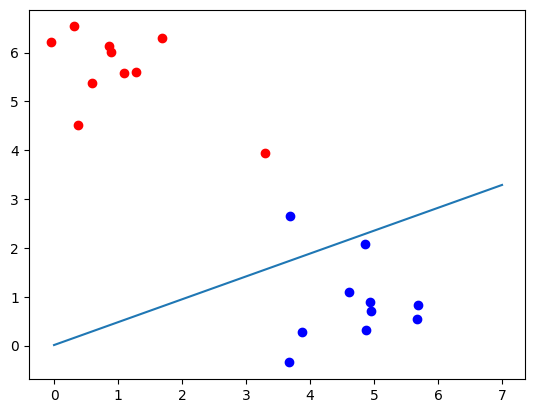

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def sigmoid_derv(x):
  return sigmoid(x)*(1-sigmoid(x))

def BCE(y_pred, y):
  return - np.sum(y*np.log(y_pred) + (1-y)*np.log(1-y_pred))

def MSE(y_pred, y):
  return np.mean((y_pred-y)**2)

def BCE_derv(y_pred, y):
  return (y_pred - y)/(y_pred*(1-y_pred))

def MSE_derv(y_pred, y):
  return 2*(y_pred-y)

W = np.array([[1.0, -2.0, 0.0]])
for i in range(10):
  Y_ = sigmoid(W.dot(X.T))
  loss = BCE(Y_, Y)
  #loss = MSE(Y_, Y)
  dLdW = (BCE_derv(Y_, Y)*Y_*(1-Y_)).dot(X)
  #dLdW = (MSE_derv(Y_, Y)*Y_*(1-Y_)).dot(X)
  W = W - 0.001*dLdW
  print(loss)
# Plot red and blue points
plt.plot(red_points[:,0], red_points[:,1], 'ro')
plt.plot(blue_points[:,0], blue_points[:,1], 'bo')
# Plot hyper plane
theta1 = W[0][0]
theta2 = W[0][1]
bias = W[0][2]

plt.plot([0, 7], [-(bias + theta1*0)/theta2, -(bias + theta1*7)/theta2])
plt.show()

## 3.4 Cài đặt Logistic Regression với MiniGrad

In [ ]:
import numpy as np

class Var:
  def __init__(self, value):
    self.value = value
    self._prev = ()
    self._backward = lambda : None
    self.grad = 0.0
    global nrecusive

  def __add__(self, other):
    if not isinstance(other, Var):
      other = Var(other)
    output = Var(self.value + other.value)
    output._prev = [self, other]
    def _backward():
      self.grad += 1.0*output.grad
      other.grad += 1.0*output.grad
    output._backward = _backward
    return output

  def __mul__(self, other):
    if not isinstance(other, Var):
      other = Var(other)
    output = Var(self.value * other.value)
    output._prev = [self, other]
    def _backward():
      self.grad += other.value*output.grad
      other.grad += self.value*output.grad
    output._backward = _backward
    return output
  # TODO: Hoàn thành đoạn code sau
  # def __neg__(self):
  #   return None
  def __rmul__(self, other):
    return None
  def __truediv__(self, other):
    return None
  def __rdiv__(self, other):
    return None
  def __radd__(self, other):
    return None
  def __sub__(self, other):
    return None
  def __pow__(self, other):
    return None
  # def exp(self):
  #   return None
  def sigmoid(self):
    return None
  def MSE(self, y):
    return None
  # END TODO

  ## CÂU HỎI: Tại sao BCE tốt hơn MSE
  def BCE(self, y):
    # TODO: Hoàn thành đoạn code sau
    # ...
    # END TODO
    return output

  def backward(self):
    self.grad = 1.0
    nodes = []
    visited = []
    def travel(node):
      if node not in visited:
        visited.append(node)
        for child in node._prev:
          travel(child)
        nodes.append(node)
    travel(self)
    nodes.reverse()
    for node in nodes:
      node._backward()

  def __repr__(self):
    return "Value: " + str(self.value)


In [ ]:
w1 = Var(1.0)
w2 = Var(-2.0)
b = Var(0.0)
for iter in range(100):
  ## CÂU HỎI: Tại sao phải khởi tạo lại
  ## Có giải pháp nào cho việc này không?
  #w1 = Var(w1.value)
  #w2 = Var(w2.value)
  #b = Var(b.value)
  #loss = sum(((w1*X[i,0] + w2*X[i,1] + b).sigmoid() - Y[i])**2 for i in range(X.shape[0]))
  loss = sum((w1*X[i,0] + w2*X[i,1] + b).sigmoid().MSE(Y[i]) for i in range(X.shape[0]))
  loss.backward()
  ## CÂU HỎI: Tại sao không hội tụ được
  # w1.value = w1.value - 0.001*w1.grad
  # w2.value = w2.value - 0.001*w2.grad
  # b.value = b.value - 0.001*b.grad
  w1 = w1 - 0.001*w1.grad
  w2 = w2 - 0.001*w2.grad
  b = b - 0.001*b.grad


# 4. Neural Network
Ở bước này ta sẽ xây dựng mạng MLP để giải quyết một bài toán phi tuyến. Trong đó hai lớp `đỏ` và `xanh` không thể bị phân tách bởi một đường thẳng:

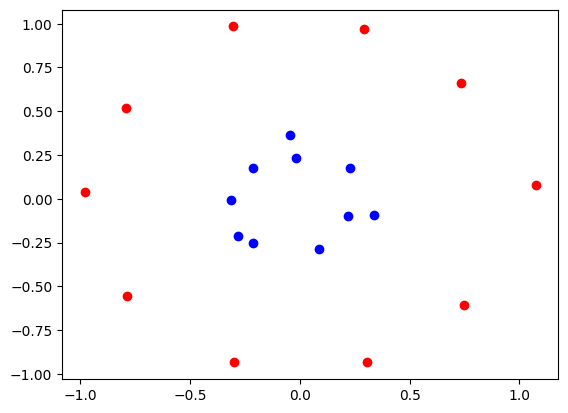

In [137]:
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import numpy as np

# Load data
X, y = make_circles(n_samples=20, factor=0.3, noise=0.05, random_state= 42)
X = np.concatenate((X, np.ones((X.shape[0], 1))), axis=1)
plt.plot(X[y==0,0], X[y==0,1], 'ro')
plt.plot(X[y==1,0], X[y==1,1], 'bo')


In [138]:
import random
class Neuron:
  def __init__(self, nin):
    """
    Init weight for a neuron:
    1. the number of weight is nin
    2. init with random value in range (-1,1)
    """
    self.weight = [Var(random.uniform(-1, 1)) for _ in range(nin)]
  def __call__(self, x):
    """
    Forward input with neuron's weight with sigmoid activation
    """
    return sum([wi*xi for wi, xi in zip(self.weight, x)]).sigmoid()
  def params(self):
    return self.weight

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]
  def __call__(self, x):
    return [neuron(x) for neuron in self.neurons]
  def params(self):
    return [param for neuron in self.neurons for param in neuron.params()]

class MLP:
  def __init__(self, nin, nouts: list()):
    sizes = [nin] + nouts
    self.layers = [Layer(sizes[i], sizes[i + 1]) for i in range(len(sizes) - 1)]
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x
  def params(self):
    return [param for layer in self.layers for param in layer.params()]


In [139]:
random.seed(9899)
nn = MLP(3, [8, 1])
learning_rate = 0.05
num_iter = 100

for iter in range(num_iter):
  loss = sum(nn(X[i,:])[0].BCE(y[i]) for i in range(y.shape[0]))
  if iter % 10 == 0:
    print(loss)
  loss.backward()
  for p in nn.params():
    p.value += - learning_rate*p.grad

Value: 13.964660846441468
Value: 13.596032095284782
Value: 12.232809042722876
Value: 5.704412537563859
Value: 0.8639809536951684
Value: 0.1301701903022872
Value: 0.02710235182559182
Value: 0.004898227507788729
Value: 0.0011719358067594939
Value: 0.0005304118443577771


Ta in ra trọng số của lớp neuron thứ 2 để biết các neuron nào ở lớp thứ nhất quan trọng và không quan trọng.

In [140]:
print(nn.layers[1].neurons[0].weight)

[Value: -5.4855936241701615, Value: -0.7263198564614093, Value: 2.9779085659955227, Value: -38.16479670193787, Value: -37.30708717672765, Value: 25.305518858576452, Value: -27.053156131407782, Value: -6.724011388792827]


In [145]:
# We investigate the importance value of a neuron by considering absolute value
important_sort = np.argsort([abs(x.value) for x in nn.layers[1].neurons[0].weight])
important_neurons = important_sort[-4:]
unimportant_neurons = important_sort[:3]

Các neuron ít quan trọng

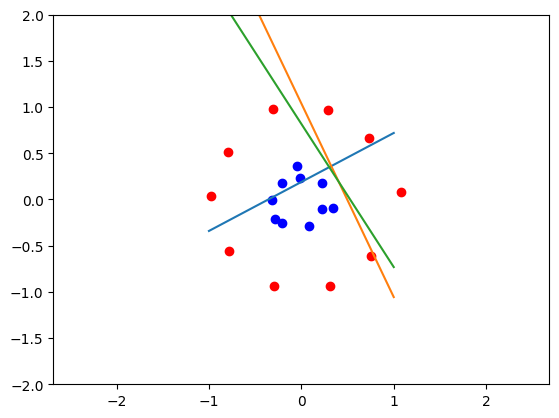

In [147]:
plt.plot(X[y==0,0], X[y==0,1], 'ro')
plt.plot(X[y==1,0], X[y==1,1], 'bo')

for nr in unimportant_neurons:
  theta1 = nn.layers[0].neurons[nr].weight[0].value
  theta2 = nn.layers[0].neurons[nr].weight[1].value
  bias = nn.layers[0].neurons[nr].weight[2].value
  plt.plot([-1, 1], [-(bias + theta1*(-1))/theta2, -(bias + theta1*1)/theta2])

plt.axis('equal')
plt.xlim([-2.0, 2.0])
plt.ylim([-2.0, 2.0])
plt.show()
plt.show()

Các neuron quan trọng

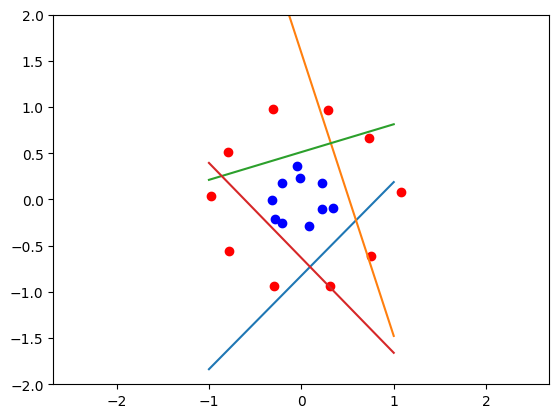

In [146]:
plt.plot(X[y==0,0], X[y==0,1], 'ro')
plt.plot(X[y==1,0], X[y==1,1], 'bo')

for nr in important_neurons:
  theta1 = nn.layers[0].neurons[nr].weight[0].value
  theta2 = nn.layers[0].neurons[nr].weight[1].value
  bias = nn.layers[0].neurons[nr].weight[2].value
  plt.plot([-1, 1], [-(bias + theta1*(-1))/theta2, -(bias + theta1*1)/theta2])

plt.axis('equal')
plt.xlim([-2.0, 2.0])
plt.ylim([-2.0, 2.0])
plt.show()
plt.show()

CÂU HỎI: bạn có nhận xét gì về các neuron quan trọng và neuron không quan trọng?